# Predicting customer churn

Using a dataset from Kaggle, which in turn comes from IBM, I attempt to train and tune an XGBoost model to act as a binary classifier to predict customer churn from various related data.

### Loading data, brief assesment, and random undersampling

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from xgboost import XGBClassifier

In [112]:
data = pd.read_csv('Customer_data.csv')
data

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


In [113]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [114]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

,SeniorCitizen,tenure,MonthlyCharges
SeniorCitizen,1.000000,0.016567,0.220173
tenure,0.016567,1.000000,0.247900
MonthlyCharges,0.220173,0.247900,1.000000


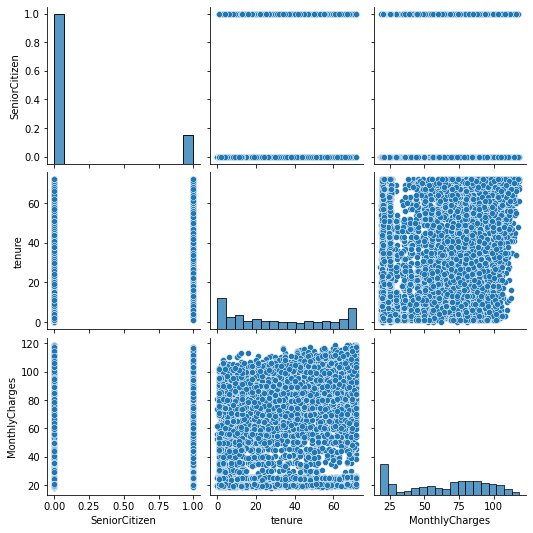

In [115]:
sn.pairplot(data)
data.corr()

In [116]:
data = data.drop('TotalCharges', axis=1) # Remove correlated total charges, as length of tenure and monthly charge exist 

<AxesSubplot:xlabel='count', ylabel='Churn'>

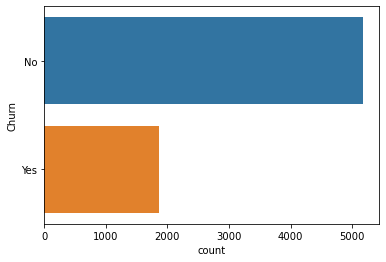

In [117]:
sn.countplot(data=data, y=data['Churn'])

Data is imbalanced enough to require some balancing, but a good nominal amount of existing churn for training purposes, therefore random undersampling of the 'No's should be sufficient. We can test if SMOTE or some other oversampling makes a difference as well, later.

In [118]:
# Could use imblearn, but let's do make our own random undersampler (and we'll make it work on not only binary measures)

def random_under(dataset=data, classes='Churn', weight = 1.0):
    
    undersampled_full_set = dataset.copy()
    counts = dataset[classes].value_counts(ascending=True)
    sample_size = counts[0]
    
    # For every category that isn't the minimum one...
    for cat in counts.index[1:]:
        rows_to_drop = len(dataset[dataset[classes]==cat]) - sample_size
        
        # ... randomly drop the number of rows there are bar the sample size
        idxs = np.random.choice(dataset[dataset[classes]==cat].index, size=rows_to_drop, replace=False)
        undersampled_full_set = undersampled_full_set.drop(idxs)
    
    return undersampled_full_set
    

In [119]:
bal_df = random_under()

<AxesSubplot:xlabel='Churn', ylabel='count'>

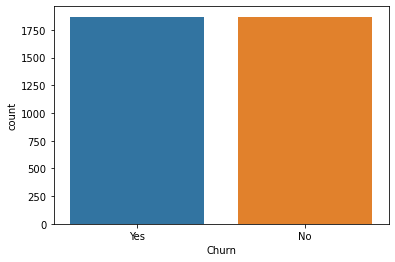

In [120]:
sn.countplot(data = bal_df, x='Churn')

And there we have it, the function adequately identifies the number of rows to drop in the majority class and randomly drops them.  
Next, encoding the categorical variables so it's suitable for the various algorithms used.

In [121]:
for col in bal_df:
    if bal_df[col].dtype == 'object':
        bal_df[col] = bal_df[col].astype('category')
        name = col+"_code"
        bal_df[name] = bal_df[col].cat.codes
        bal_df.drop(columns=col, axis=1, inplace=True)
    else:
        pass
bal_df

,SeniorCitizen,tenure,MonthlyCharges,customerID_code,gender_code,Partner_code,Dependents_code,PhoneService_code,MultipleLines_code,InternetService_code,OnlineSecurity_code,OnlineBackup_code,DeviceProtection_code,TechSupport_code,StreamingTV_code,StreamingMovies_code,Contract_code,PaperlessBilling_code,PaymentMethod_code,Churn_code
2,0,2,53.85,1359,1,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,0,45,42.30,2945,1,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,2,70.70,3466,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1
5,0,8,99.65,3490,0,0,0,1,2,1,0,0,2,0,2,2,0,1,2,1
8,0,28,104.80,2984,0,1,0,1,2,1,0,0,2,2,2,2,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,0,12,60.65,2928,0,0,0,0,1,0,0,2,2,2,2,2,1,0,2,0
7037,0,72,21.15,914,0,0,0,1,0,2,1,1,1,1,1,1,2,1,0,0
7038,0,24,84.80,2588,1,1,1,1,2,0,2,0,2,2,2,2,1,1,3,0
7039,0,72,103.20,789,0,1,1,1,2,1,0,2,2,0,2,2,1,1,1,0


### XGBoost Classification with KFold Cross-Validation and Partial Hyperparameter Tuning via Grid Search

In [103]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split

In [14]:
kfold = KFold(10, random_state=1, shuffle=True)

X = np.array(bal_df.iloc[:, :-1])
y = np.array(bal_df['Churn_code'])

accs = []
depths = []
etas = []

# Some parameter tuning to optimise the learning rate and max depth of the trees used
for depth in range(1, 10):
    for eta in np.arange(0.001, 0.2, 0.001): 
        model =  XGBClassifier(booster='gbtree', eta=eta, max_depth=depth)
        scores = cross_val_score(model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)
        accs.append(scores.mean())
        etas.append(eta)
        depths.append(depth)


Optimal value for learning rate is 0.0360, and optimal max depth is 4, giving an accuracy of 76.65%


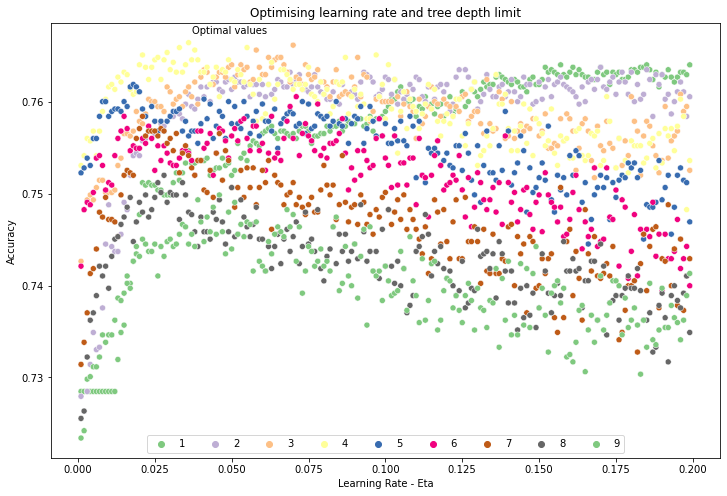

In [15]:
fig, ax = plt.subplots(figsize=(12,8))

sn.scatterplot(x=etas, y=accs, hue=depths, legend='full', palette='Accent')
plt.xlabel('Learning Rate - Eta')
plt.ylabel('Accuracy')
plt.title('Optimising learning rate and tree depth limit')
ax.legend(loc='lower center', ncol=9)

optimal_eta = etas[accs.index(max(accs))]
optimal_depth = depths[accs.index(max(accs))]

plt.annotate('Optimal values', (optimal_eta+0.001, max(accs)+0.001 ))

print("Optimal value for learning rate is {:.4f}, and optimal max depth is {}, giving an accuracy of {:.2f}%".format(optimal_eta, optimal_depth, max(accs)*100))

### Model Improvement: Hyperparameter Tuning Via Bayesian Search Optimisation on a Larger Grid

In [107]:
from skopt import BayesSearchCV

In [108]:
import warnings
warnings.filterwarnings('ignore')

params={'min_child_weight': (0, 50,),
        'max_depth': (0, 10),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'lambda':(0.00001, 100),
        'alpha':(0.00001, 100),
        'eta':(0.01,0.2,'log-uniform')
        }

X = np.array(bal_df.iloc[:, :-1])
y = np.array(bal_df['Churn_code'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

bayes=BayesSearchCV(XGBClassifier(verbosity=0),params,n_iter=10,scoring='neg_mean_squared_error',cv=10,random_state=2702)
results = bayes.fit(X_train,y_train)
print(results.best_params_)

OrderedDict([('alpha', 17.01568113092442), ('colsample_bytree', 0.5694033231517627), ('eta', 0.15846010264805785), ('lambda', 16.682739046917703), ('max_depth', 5), ('min_child_weight', 6), ('subsample', 0.5469566103696956)])


In [106]:
opt_model = XGBClassifier()
opt_model.set_params(**results.best_params_)

scores = cross_val_score(opt_model, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)

print("New optimised accuracy = {:.2f}%".format(scores.mean()*100))

New optimised accuracy = 77.07%


As you can see the validated accuracy of the model has been improved very slightly by expanding the search and changing the methodology; however the real benefit is that this tuning process is much more efficient one in terms of runtime, despite the increased size of the hyperparameter search space.

### Comparing to logistic regression

In [86]:
from sklearn.linear_model import LogisticRegression

In [93]:
log_params = {'max_iter':(50,120),
              'fit_intercept':(True,False),
              'C':(0.001,10),
              'tol':(0.000001,0.01)
             }

log_bayes = BayesSearchCV(LogisticRegression(), log_params, n_iter=10, scoring='neg_mean_squared_error', cv=10, random_state=21)
log_results = log_bayes.fit(X_train, y_train)

opt_log = LogisticRegression(**log_results.best_params_)

log_scores = cross_val_score(opt_log, X, y, scoring='accuracy', cv=kfold, n_jobs=-1)

print("Logistic regression optimised kfold accuracy = {:.2f}%".format(log_scores.mean()*100))

Logistic regression optimised kfold accuracy = 76.22%
